In [1]:
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

# Лабораторная работа №8, часть 1

In [3]:
from itertools import islice

import numpy as np
from matplotlib import pyplot as plt
from scipy.io import loadmat
from scipy.stats import norm as scipy_norm

from common import f1_score, threshold_gen

## Загрузка данных

In [4]:
SERVER_DATA = loadmat("ex8data1.mat")
X = SERVER_DATA["X"]

DELAY = X[:, 0]
BANDWITH = X[:, 1]

X_VAL = SERVER_DATA["Xval"]
Y_VAL = SERVER_DATA["yval"]
Y_VAL_FLATTENED = np.ravel(Y_VAL)

DELAY_VAL = X_VAL[:, 0]
BANDWITH_VAL = X_VAL[:, 1]

### Диаграмма рассеяния входных данных

#### Обучающая выборка

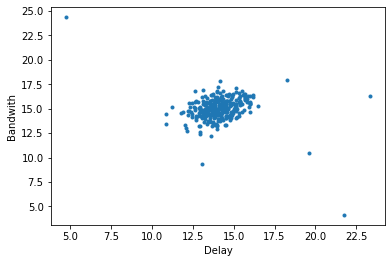

In [5]:
train_data_fig, train_data_axes = plt.subplots()
train_data_axes.scatter(X[:, 0], X[:, 1], s=9)
train_data_axes.set_xlabel("Delay")
train_data_axes.set_ylabel("Bandwith")
plt.show()

#### Валидационная выборка

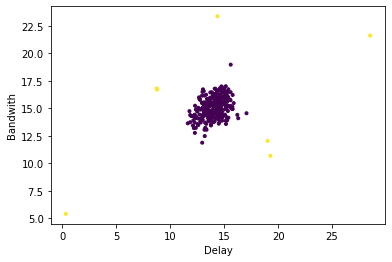

In [6]:
plt.scatter(X_VAL[:, 0], X_VAL[:, 1], c=Y_VAL[:, 0], s=9)
plt.xlabel("Delay")
plt.ylabel("Bandwith")
plt.show()

### Гистограммы случайных величин

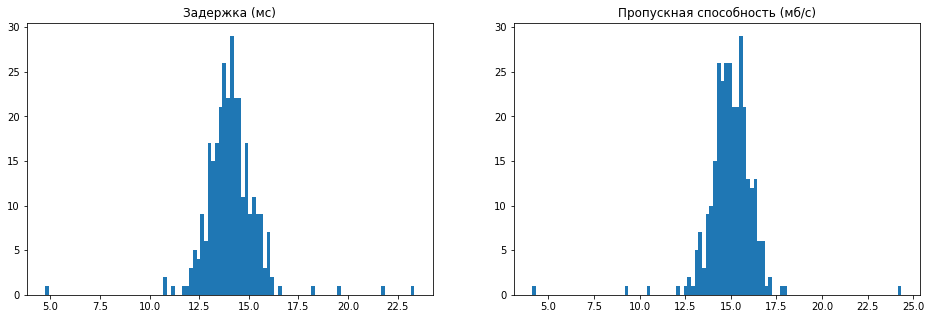

In [7]:
figure, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 5))

ax1.hist(X[:, 0], bins=100)
ax1.set_title("Задержка (мс)")

ax2.hist(X[:, 1], bins=100)
ax2.set_title("Пропускная способность (мб/c)")
plt.show()

### Параметры распределения случайных величин

In [8]:
means = np.mean(X, axis=0)
variances = np.var(X, axis=0)
scales = np.sqrt(variances)

print(f"Means = {means}")
print(f"Variances = {variances}")
print(f"Scales = {scales}")

Means = [14.11222578 14.99771051]
Variances = [1.83263141 1.70974533]
Scales = [1.35374717 1.3075723 ]


### Оценка параметров случайной величины

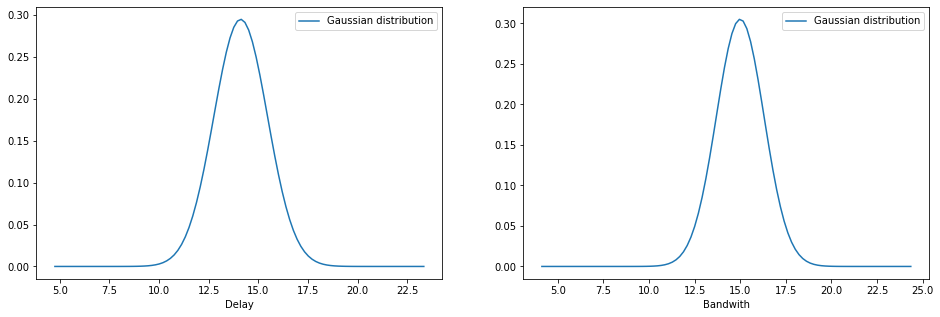

In [9]:
figure, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 5))

# Delay graph
delay_max = max(DELAY)
delay_min = min(DELAY)
delay_pdf_graph_x = np.linspace(delay_min, delay_max, 100)

delay_mean = means[0]
delay_scale = scales[0]
# Delay normal probability
delay_norm = scipy_norm(delay_mean, delay_scale)
delay_pdf_graph_y = delay_norm.pdf(delay_pdf_graph_x)

ax1.plot(delay_pdf_graph_x, delay_pdf_graph_y, label="Gaussian distribution")
ax1.set_xlabel("Delay")
ax1.legend()

# Bandwith graph
bandwith_max = max(BANDWITH)
bandwith_min = min(BANDWITH)
bandwith_pdf_graph_x = np.linspace(bandwith_min, bandwith_max, 100)

bandwith_mean = means[1]
bandwith_scale = scales[1]
# Bandwith normal probability
bandwith_norm = scipy_norm(bandwith_mean, bandwith_scale)
bandwith_pdf_graph_y = bandwith_norm.pdf(bandwith_pdf_graph_x)

ax2.plot(bandwith_pdf_graph_x, bandwith_pdf_graph_y, label="Gaussian distribution")
ax2.set_xlabel("Bandwith")
ax2.legend()

plt.show()

### График плотности распределения в виде изолиний

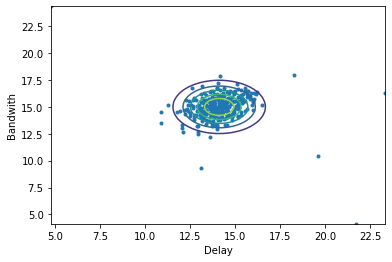

In [10]:
delay_x_meshed, bandwith_x_meshed = np.meshgrid(delay_pdf_graph_x, bandwith_pdf_graph_x)
density_surface = (
    delay_norm.pdf(np.ravel(delay_x_meshed))
    * bandwith_norm.pdf(np.ravel(bandwith_x_meshed))
).reshape(delay_x_meshed.shape)
train_data_axes.contour(delay_x_meshed, bandwith_x_meshed, density_surface)
train_data_fig


### F1-мера
\begin{equation}
Precision = \frac{TP}{TP + FP} \\
Recall = \frac{TP}{TP + FN} \\
F = 2 \frac{Precision \times Recall}{Precision + Recall}
\end{equation}

In [11]:
?f1_score

### Получение вероятностей для примеров

In [12]:
probabilities_val = delay_norm.pdf(DELAY_VAL) * bandwith_norm.pdf(BANDWITH_VAL)


### Подбор значения порога для обнаружения аномалий

In [13]:
OPTIMAL_THRESHOLD = None
best_score = 0
for threshold in islice(threshold_gen(), 8):
    anomaly_hypotheses = probabilities_val < threshold
    score = f1_score(anomaly_hypotheses, Y_VAL_FLATTENED)
    if score > best_score:
        best_score = score
        OPTIMAL_THRESHOLD = threshold
    print(f"threshold = {threshold:6.2}\t score = {score:.2%}")

print("=" * 69)
print(f"Optimal threshold = {OPTIMAL_THRESHOLD:.2}")

threshold =    0.1	 score = 5.70%
threshold =   0.05	 score = 12.50%
threshold =   0.01	 score = 66.67%
threshold =  0.005	 score = 77.78%
threshold =  0.001	 score = 82.35%
threshold = 0.0005	 score = 82.35%
threshold = 0.0001	 score = 87.50%
threshold =  5e-05	 score = 87.50%
Optimal threshold = 0.0001


#### Аномальные наблюдения

6 anomalies found.


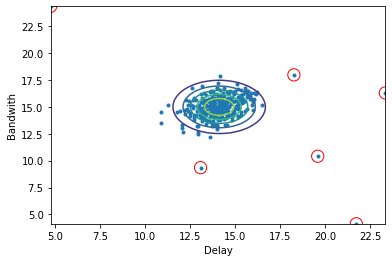

In [14]:
probabilities_train = bandwith_norm.pdf(BANDWITH) * delay_norm.pdf(DELAY)
anomalies_train = X[probabilities_train < OPTIMAL_THRESHOLD]
anomalies_count = anomalies_train.shape[0]
print(f"{anomalies_count} anomal{'y' if anomalies_count == 1 else 'ies'} found.")
train_data_axes.scatter(
    anomalies_train[:, 0],
    anomalies_train[:, 1],
    s=150,
    facecolors="none",
    edgecolors="red",
)
train_data_fig